In [1]:
import numpy as np
import matplotlib.pyplot as pyp
import sys
import os
import matplotlib
import datetime
import pandas as pd
import csv
import scipy.interpolate as interpolate
import glob
import numpy.fft as fft
%matplotlib inline

In [2]:
pyp.rcParams['font.size']=18

In [3]:
dirc_pre = './'
NFM_dirc = '%s/MountaintopNoiseFigure/'%(dirc_pre)
ant_dirc = "%s/Antennas/"%(dirc_pre)
predictDirc = '%s/PredictedSpectra'%(dirc_pre)
outDirc = "%s/comparisons/"%(dirc_pre)
measDirc = '/home/radio/data/beacon_august2018/'

In [4]:
def read_line(line, old=False, samprate=1e-9):
    if(old):
        stuff = line.split(',')
        channel = int(stuff[0])
        eventid = int(stuff[1])
        vals = []
        vals.append(float(stuff[2][2:]))
        for i in range(3, len(stuff)-1):
            vals.append(float(stuff[i]))
        vals.append(float(stuff[len(stuff)-1][:-4]))
        return pd.DataFrame({'channel': channel, 'eventid': eventid, 'volt': pd.Series(np.array(vals), index=np.arange(0., len(vals))*samprate)})
    else:
        stuff = line.split(',')
        #print("STUFF", stuff, "END STUFF")
        channel = int(stuff[0])
        eventid = int(stuff[1])
        timestamp = stuff[2]
        samprate = float(stuff[3])
        trigtime = float(stuff[4])
        #print("HEADER IN THIS LINE: ", channel, eventid, timestamp, samprate, trigtime, "END HEADER")
        vals = []
        vals.append(float(stuff[5][2:]))
        for i in range(6, len(stuff)-1):
            vals.append(float(stuff[i]))
        #print("VALS", vals, "END VALS")
        #print("END OF STUFF \\", stuff[len(stuff)-1], "\\")
        try:
            #print(4)
            vals.append(float(stuff[len(stuff)-1][:-4]))
        except:
            try:
                #print(3)
                vals.append(float(stuff[len(stuff)-1][:-3]))
            except:
                try:
                    #print(2)
                    vals.append(float(stuff[len(stuff)-1][:-2]))
                except:
                    try:
                        #print(1)
                        vals.append(float(stuff[len(stuff)-1][:-1]))
                    except:
                        #print(0)
                        print("", end=' ')
                        
        #print("made it", eventid)
        return pd.DataFrame({'channel': channel, 'eventid': eventid, 'samprate': samprate, 'trigtime': trigtime, 
                             'volt': pd.Series(np.array(vals), index=np.arange(0., len(vals))*samprate)})



In [5]:
#### NOTE: This only works for a 2-channel measurement where the channels used are 1 and 2!
def read_tekscope_file(fname):
    events = {}
    with open(fname, 'r') as fi:
        for line in fi:
            #print(line)
            event = read_line(line)
            #print(event.channel)
            if(event.channel.iloc[0] == 1):
                evs = []
            evs.append(event)
            if(event.channel.iloc[0] == 2):
                events[event.eventid.iloc[0]] = evs
                #print(event.eventid.iloc[0], events[event.eventid.iloc[0]])
    #print(events)
    #print( pd.DataFrame(events) )
    return pd.DataFrame(events)

In [6]:
channel_names = {1: 'After Stage2', 2: 'After Tunnel Diode', 3: 'Chan3', 4: 'Chan4'}
def draw_wave(events, eventid):
    event = events[eventid]

    for ich in range(0, 2):
        channel = event[ich]
        #print("Drawing channel ", channel.channel.iloc[0], " event ", channel.eventid.iloc[0], " with ", len(
        #    channel.volt), " points ")
        pyp.figure(1, figsize=(12,4))
        ax = pyp.subplot(1, 2, ich+1)
        pyp.plot(channel.volt.index*1e9, channel.volt)
        ax.set_title(channel_names[ich+1])
        fv = fft.rfft(channel.volt.values)
        freq = fft.rfftfreq(len(channel.volt.values),
                            d=channel.samprate.iloc[0])
        
def draw_channel(events, eventid, ich):
    event = events[eventid]

    channel = event[ich]
    #print("Drawing channel ", channel.channel.iloc[0], " event ", channel.eventid.iloc[0], " with ", len(
    #    channel.volt), " points ")
    pyp.figure(1, figsize=(12,4))
    ax = pyp.subplot(1, 2, 1)
    pyp.plot(channel.volt.index*1e9, channel.volt)
    ax.set_title("Waveform")
    
    ax = pyp.subplot(1,2,2)
    fv = fft.rfft(channel.volt.values)
    freq = fft.rfftfreq(len(channel.volt.values),
                        d=channel.samprate.iloc[0])
    pyp.semilogy(freq/1e6, abs(fv)**2)
    ax.set_title("Power Spectrum")

In [7]:
def getData(run, date, instr):
    
    measSpecHead = []
    measSpectra = []
    measRatesHead = []
    measRates = []
    measWaves = []
     
    for ins in instr:
        if ins == 'specanalyzer':
            globName = "%s/%d/%s_run%d_*.hdf5"%(measDirc,date,ins,run)
            measFi = glob.glob(globName)[-1]
            measSpecHead = pd.read_hdf(measFi, key='header')
            measSpectra = pd.read_hdf(measFi, key='spectra')
            print("Spectrum Analyzer File Name", measFi)
        elif ins == 'photonCounter':
            globName = "%s/%d/%s_run%d_*.hdf5"%(measDirc,date,ins,run)
            measFi = glob.glob(globName)[-1]
            print("Photon Counter File Name", measFi)
            measRatesHead = pd.read_hdf(measFi, key='header')
            measRates = pd.read_hdf(measFi, key='rates')
        elif ins == 'tekScope':
            globName = "%s/%s/%s/%s_run%d_*.csv"%(measDirc,date,date,ins,run)
            measFi = glob.glob(globName)[-1]
            print("Scope File Name ", measFi)
            measWaves = read_tekscope_file(measFi)

    return measSpecHead, measSpectra, measRatesHead, measRates, measWaves

In [8]:
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                        12, 20180809, [ 'specanalyzer'])

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180809/specanalyzer_run12_2018-08-09_16-33-43.hdf5


In [9]:
measRatesHead

[]

In [10]:
def plotSpectrum(headSet, specSet, key, label=''):
        head = headSet[key]
        spec = specSet[key]
        
        pyp.figure(1,figsize=(8, 16))
        pyp.subplot(2, 1, 1)
        pyp.title(head['DATE'])
        pyp.plot(spec.freq_hz/1e6, spec.power_dBm, label=label)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Power (dBm)")
        pyp.subplot(2, 1, 2)
        pyp.plot(spec.freq_hz/1e6, spec.power_dBm - 10. *
                 np.log10(head['rbw_hz']/1e6), label=label)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Power Spectral Density (dBm/MHz)")
        #pyp.show()

def plotSpectrogram(headSet, specSet, label=''):
        pyp.figure(2,figsize=(8, 16))
        pyp.subplot(2, 1, 1)
        pyp.title(label)
        timestamps = headSet.keys()

        # Get all the time stamps
        datestrf = '%Y-%m-%d-%W-%H-%M-%S'
        datetimestamps = [datetime.datetime.strptime(
            ts, datestrf) for ts in timestamps]

        starttime = datetimestamps[0]
        tdelta = np.zeros(len(datetimestamps))
        for i, ts in enumerate(datetimestamps):
            tdelta[i] = (ts - starttime).total_seconds()

        # Setup the spectrogram array
        spectrogram = np.zeros((len(datetimestamps), len(
            specSet[timestamps[0]]['power_dBm'])))
        for i, dt in enumerate(tdelta):
            timestamp = timestamps[i]
            spec = specSet[timestamp]['power_dBm']
            spectrogram[i, :] = spec

        # make a mesh for plotting
        freqmesh, timemesh = np.meshgrid(
            specSet[timestamp]['freq_hz']/1e6, tdelta)
        # plot!
        pyp.pcolormesh(freqmesh, timemesh, spectrogram,vmin=-80,vmax=-20)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Time(s)")
        pyp.title(starttime.strftime(format=datestrf))
        cbar = pyp.colorbar()
        cbar.set_label("Power (dBm)")

        # plot!
        pyp.subplot(2, 1, 2)
        pyp.pcolormesh(freqmesh, timemesh, spectrogram -
                       10.*np.log10(headSet[timestamp]['rbw_hz']/1e6),
                      vmin=-80,vmax=-20)
        pyp.xlabel("Frequency (MHz)")
        pyp.ylabel("Time(s)")
        pyp.title(starttime.strftime(format=datestrf))
        cbar = pyp.colorbar()
        cbar.set_label("Power (dBm/MHz)")

In [11]:
def plotThresholdScan(headSet, ratesSet, label=''):
    pyp.semilogy(ratesSet.thresholdmV*10**3, ratesSet.rates, linewidth=1,label=label)
    pyp.xlabel("Threshold Voltage (mV)")
    pyp.ylabel("Rates (Hz)")
    pyp.xlim(0,300)

In [12]:
def plotRatesTime(headSet, ratesSet, label=''):
    pyp.semilogy(ratesSet.timestamp, ratesSet.rates, linewidth=1, label='')
    pyp.xlabel("Time (s)")
    pyp.ylabel("Rates (Hz)")

# VHF Vpol East Side

## Threshold Scans

Photon Counter File Name /home/radio/data/beacon_august2018//20180809/photonCounter_run14_2018-08-09_16-50-24.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180809/photonCounter_run15_2018-08-09_16-58-24.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run3_2018-08-10_10-20-55.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run7_2018-08-10_11-42-26.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run6_2018-08-10_11-07-05.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run4_2018-08-10_10-29-23.hdf5


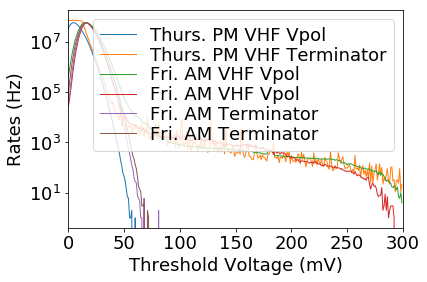

In [13]:
dates = [20180809, 20180809, 20180810, 20180810, 20180810, 20180810]
runs  = [14,            15,         3,        7,       6,         4]
names = ['Thurs. PM VHF Vpol', 'Thurs. PM VHF Terminator', 
         'Fri. AM VHF Vpol', 'Fri. AM VHF Vpol', 'Fri. AM Terminator', 'Fri. AM Terminator' ]


for i,r in enumerate(runs):
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'photonCounter'])
    plotThresholdScan(measRatesHead, measRates, label=names[i])
    
pyp.legend(labelspacing=0.1)
pyp.savefig(outDirc + "/observatory_esat_vhf_vpol_thresholdscans.pdf",bbox_inches='tight')

Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run3_2018-08-10_10-20-55.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run7_2018-08-10_11-42-26.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run6_2018-08-10_11-07-05.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180810/photonCounter_run4_2018-08-10_10-29-23.hdf5


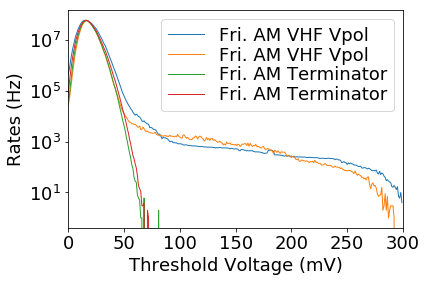

In [14]:
n = 2
for j,r in enumerate(runs[n:]):
    i = j + n
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'photonCounter'])
    plotThresholdScan(measRatesHead, measRates, label=names[i])
    
pyp.legend(labelspacing=0.1)
pyp.savefig(outDirc + "/observatory_east_fri_vhf_vpol_thresholdscans.pdf",bbox_inches='tight')

Photon Counter File Name /home/radio/data/beacon_august2018//20180809/photonCounter_run14_2018-08-09_16-50-24.hdf5
Photon Counter File Name /home/radio/data/beacon_august2018//20180809/photonCounter_run15_2018-08-09_16-58-24.hdf5


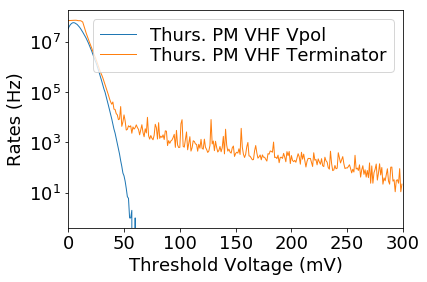

In [15]:
n = 2
for j,r in enumerate(runs[:n]):
    i = j
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'photonCounter'])
    plotThresholdScan(measRatesHead, measRates, label=names[i])
    
pyp.legend(labelspacing=0.1)
pyp.savefig(outDirc + "/observatory_east_thurs_vhf_vpol_thresholdscans.pdf",bbox_inches='tight')

## Spectra

### Vpol

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180809/specanalyzer_run12_2018-08-09_16-33-43.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180809/specanalyzer_run13_2018-08-09_16-39-10.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run1_2018-08-10_10-06-52.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run2_2018-08-10_10-16-45.hdf5


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


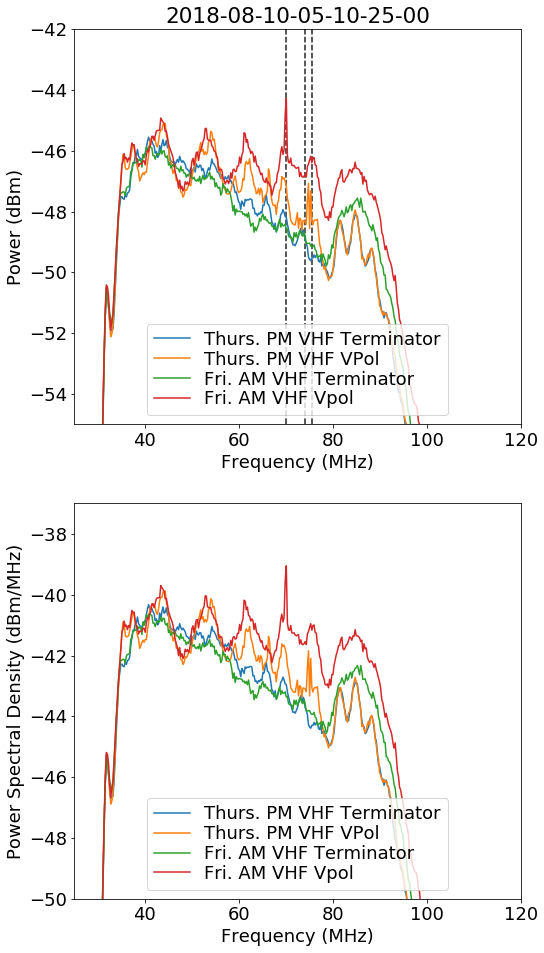

In [16]:
dates = [20180809, 20180809, 20180810, 20180810]
runs  = [12,             13,         1,        2]
names = ['Thurs. PM VHF Terminator', 'Thurs. PM VHF VPol', 'Fri. AM VHF Terminator', 'Fri. AM VHF Vpol']

for i,r in enumerate(runs):
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'specanalyzer'])

    for j in range(1):#len(measSpecHead.keys())):
        plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j],
                    label=names[i])
    pyp.subplot(2,1,1)
    pyp.legend(labelspacing=0.1,loc='lower center')
    pyp.xlim(25,120)
    pyp.ylim(-55,-42)
    pyp.vlines([70,74,75.5], -55,-42, linestyles='--', alpha=0.3)
    pyp.subplot(2,1,2)
    pyp.legend(labelspacing=0.1,loc='lower center')
    pyp.xlim(25,120)
    pyp.ylim(-50,-37)
    
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectra.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run8_2018-08-10_12-02-54.hdf5


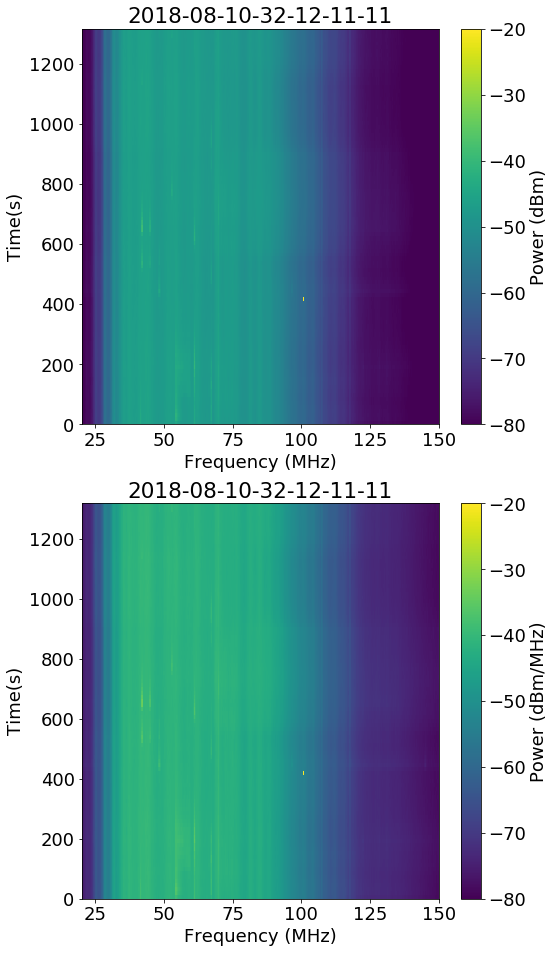

In [17]:
dates = [20180810, 20180810, 20180810, 20180810, 20180810]
runs  = [8,        9,        10,       11,       12]
names = ['','','','','','']

i=0
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectrogram8.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run9_2018-08-10_12-42-03.hdf5


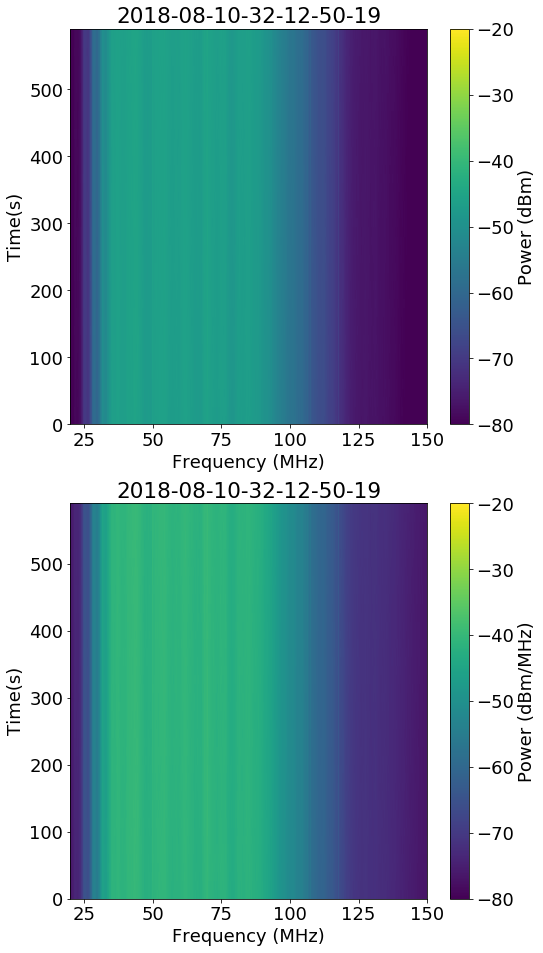

In [18]:
dates = [20180810, 20180810, 20180810, 20180810, 20180810]
runs  = [8,        9,        10,       11,       12]
names = ['','','','','','']

i=1
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectrogram9.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run10_2018-08-10_12-53-21.hdf5


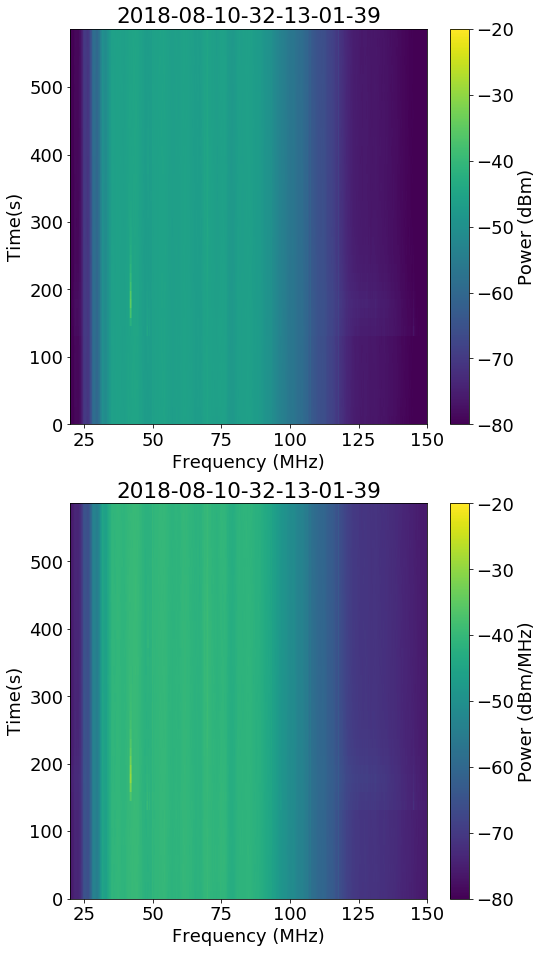

In [19]:
dates = [20180810, 20180810, 20180810, 20180810, 20180810]
runs  = [8,        9,        10,       11,       12]
names = ['','','','','','']

i=2
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectrogram10.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run11_2018-08-10_13-06-13.hdf5


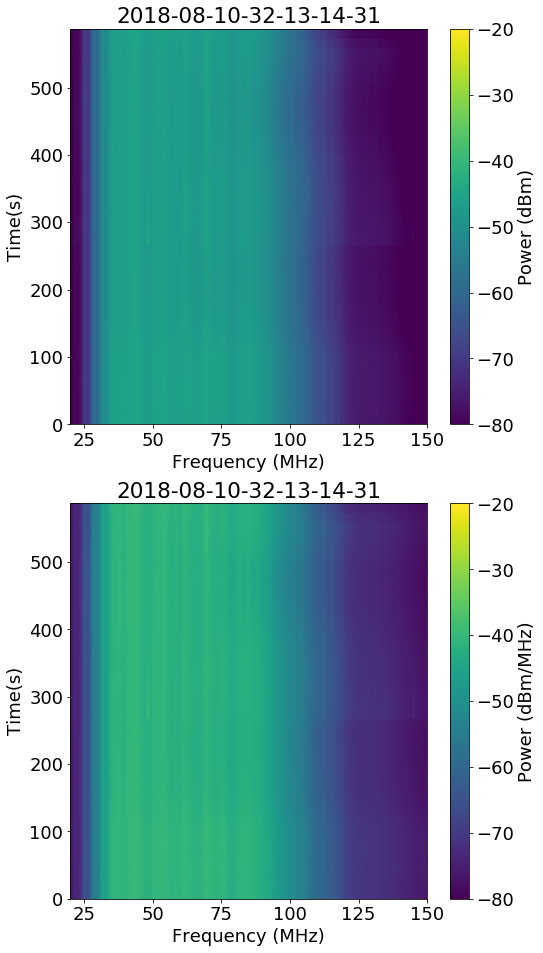

In [20]:
dates = [20180810, 20180810, 20180810, 20180810, 20180810]
runs  = [8,        9,        10,       11,       12]
names = ['','','','','','']

i=3
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectrogram11.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run12_2018-08-10_13-18-13.hdf5


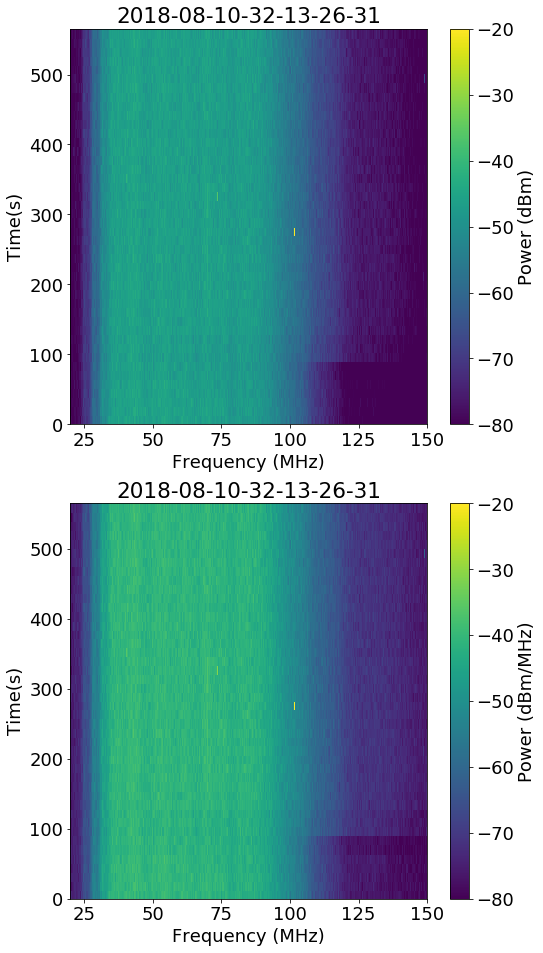

In [21]:
dates = [20180810, 20180810, 20180810, 20180810, 20180810]
runs  = [8,        9,        10,       11,       12]
names = ['','','','','','']

i=4
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectrogram12.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run15_2018-08-10_13-47-07.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run17_2018-08-10_14-13-19.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run18_2018-08-10_14-25-32.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run19_2018-08-10_14-41-04.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run20_2018-08-10_14-53-00.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run21_2018-08-10_15-04-41.hdf5


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


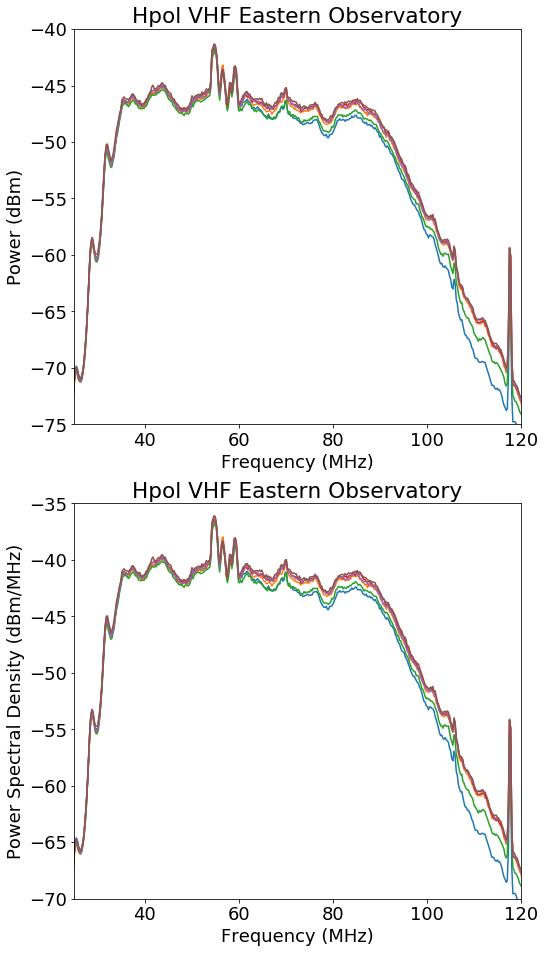

In [22]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

for i,r in enumerate(runs):
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'specanalyzer'])

    for j in range(1):#len(measSpecHead.keys())):
        plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j],
                    label=names[i])
    pyp.subplot(2,1,1)
    #pyp.legend(labelspacing=0.1,loc='lower center')
    pyp.xlim(25,120)
    pyp.ylim(-75,-40)
    pyp.title("Hpol VHF Eastern Observatory")
    #pyp.vlines([70,74,75.5], -55,-42, linestyles='--', alpha=0.3)
    pyp.subplot(2,1,2)
    #pyp.legend(labelspacing=0.1,loc='lower center')
    pyp.xlim(25,120)
    pyp.ylim(-70,-35)
    pyp.title("Hpol VHF Eastern Observatory")
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_spectra.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run17_2018-08-10_14-13-19.hdf5


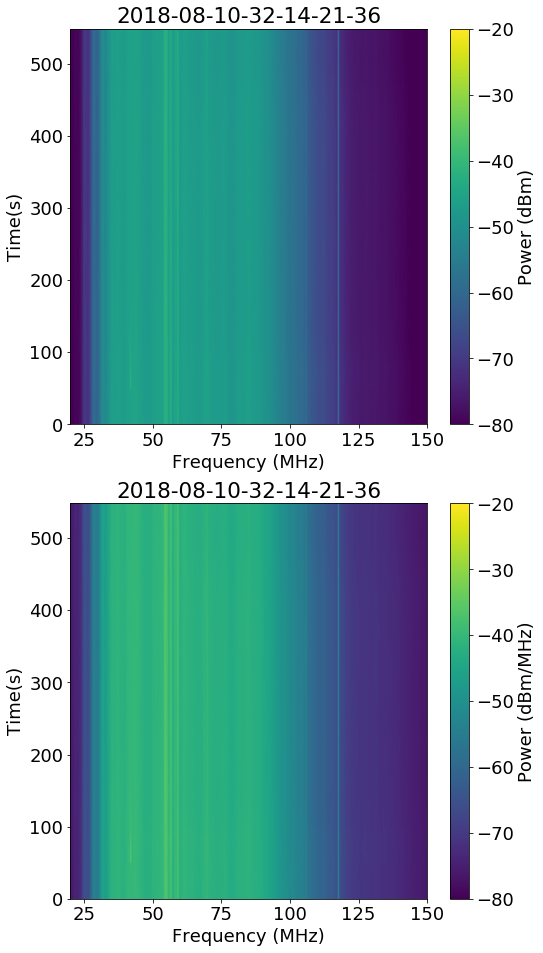

In [23]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

i=1
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_spectrogram17.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run18_2018-08-10_14-25-32.hdf5


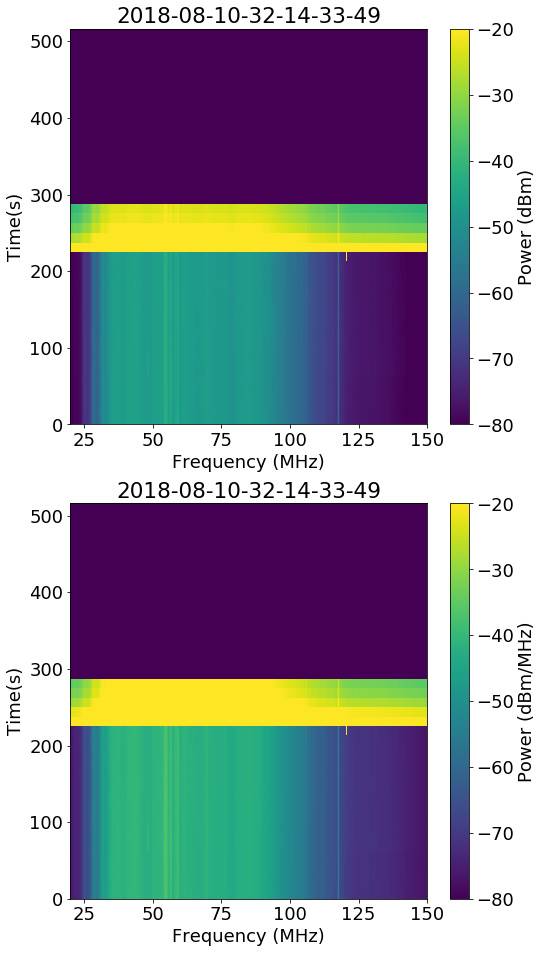

In [24]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

i=2
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_spectrogram18.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run19_2018-08-10_14-41-04.hdf5


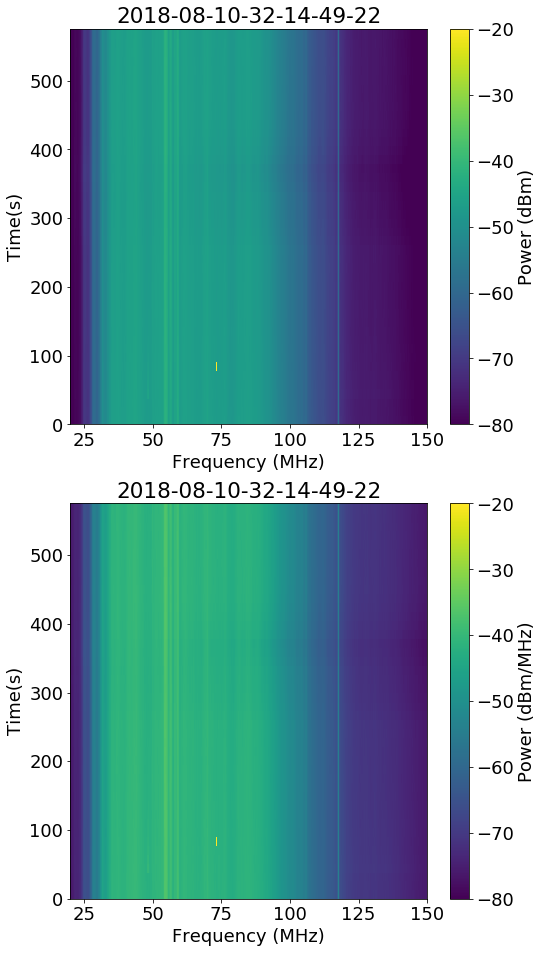

In [25]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

i=3
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_spectrogram19.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run20_2018-08-10_14-53-00.hdf5


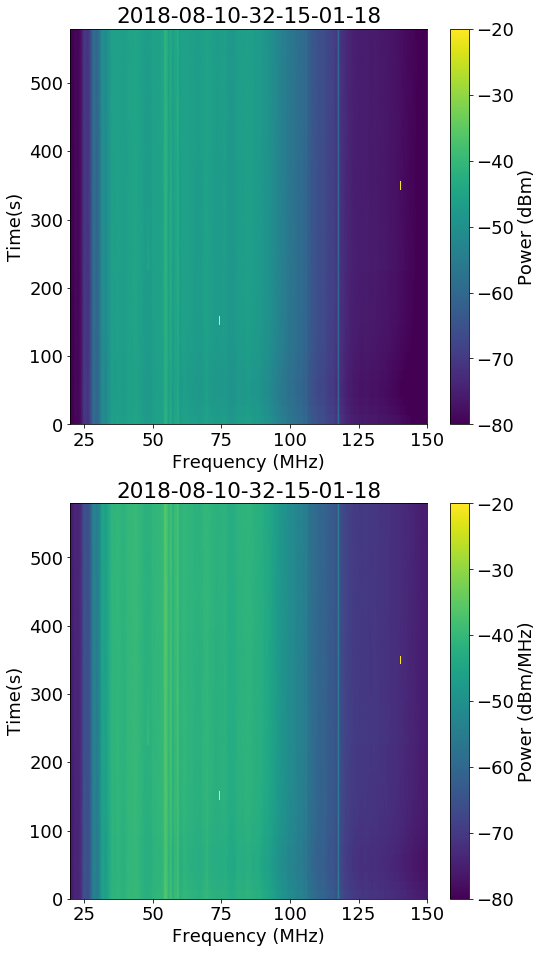

In [26]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

i=4
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_spectrogram20.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180810/specanalyzer_run21_2018-08-10_15-04-41.hdf5


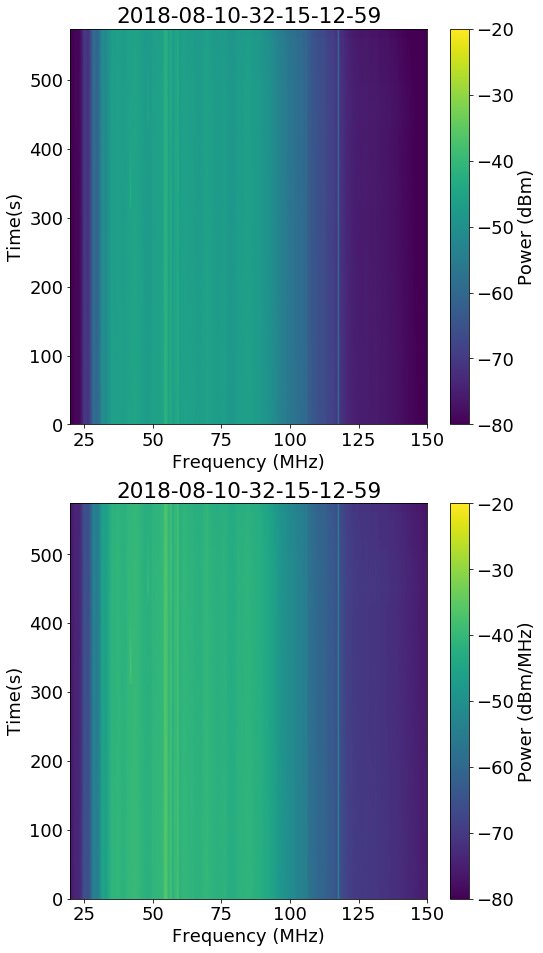

In [27]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

i=5
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_spectrogram21.pdf",bbox_inches='tight')

## Waveforms

## Vpol

In [28]:
dates = [20180810, 20180810, 20180810]
runs  = [       8,        9,       10]
names = ['Fri. AM VHF Vpol', 'Fri. AM VHF Vpol', 'Fri. Am VHF Vpol']

i = 0
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180810/20180810/tekScope_run8_20180810_12-02-57-903169.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


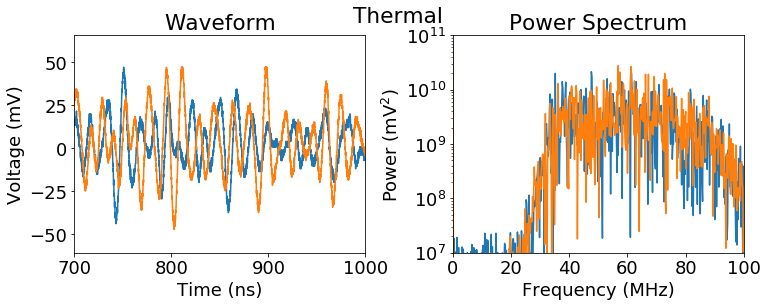

In [29]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

therm_ind = [4,6,7,8,16,19]
therm_ind = [16,19]
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Thermal")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(700, 1000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e11)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_thermal_scope.jpg",bbox_inches='tight')

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


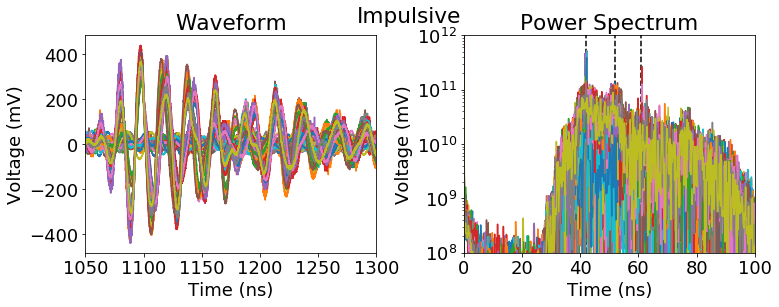

In [30]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

ind = [1,2,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,
       33,34,35,36,38,39,40,41,43,44,45,46,47,48,49,50,51,52,53,
       54,55,56,57,58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,
       76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,
       95,96,97,98,99]

for eid in measWaves.keys()[ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulsive")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(1050, 1300)
#pyp.vlines([1080,1097], -500,500, linestyles='--')

pyp.subplot(1,2,2)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(0,100)
pyp.ylim(1e8,1e12)
pyp.vlines([42,52,61], 1e8,1e13, linestyles='--')

pyp.subplots_adjust(wspace=0.3)
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_impulses_scope.jpg",bbox_inches='tight')

## Hpol

In [31]:
dates = [20180810] * 6
runs  = [15, 17, 18, 19, 20, 21]
names = ['Hpol']*6

i = 1
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180810/20180810/tekScope_run17_20180810_14-13-22-573474.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


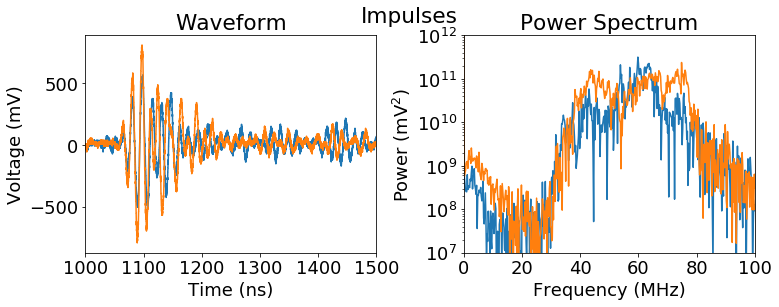

In [32]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

therm_ind = [4,6,7,8,16,19]
therm_ind = [16,19]
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulses")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(1000, 1500)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e12)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_impulse_scope.jpg",bbox_inches='tight')

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


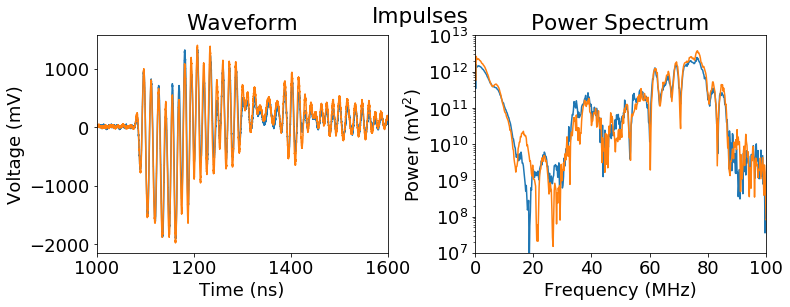

In [33]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

therm_ind = [7,8]
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulses")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(1000, 1600)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e13)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_bigpulses_scope.jpg",bbox_inches='tight')

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


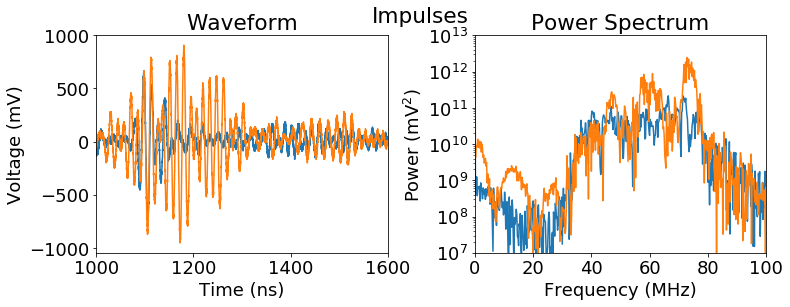

In [34]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

therm_ind = [43,44]
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulses")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(1000, 1600)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e13)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_impulses2_scope.jpg",bbox_inches='tight')

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


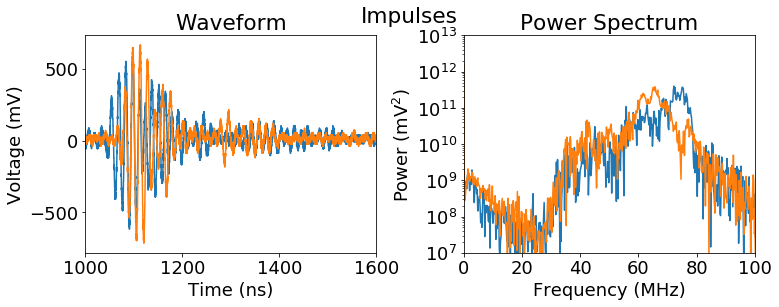

In [35]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

therm_ind = [49,50]
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulses")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(1000, 1600)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e13)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_impulses3_scope.jpg",bbox_inches='tight')

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


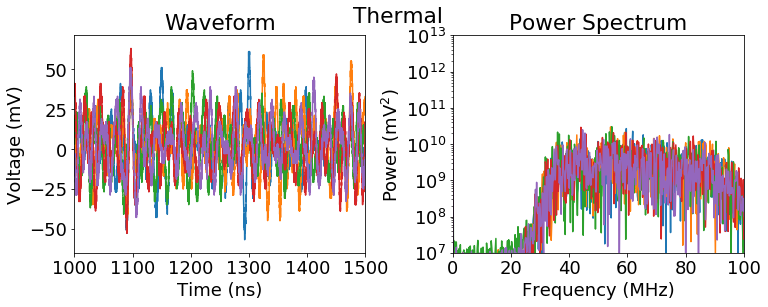

In [36]:
# run 8 good traces
#[1,2,4,6,7,8,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,33,34,
# 35,36,38,39,40,41,43,44,45,46,,47,48,49,50,51,52,53,54,55,56,57,
# 58,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,
# 82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

therm_ind = range(95,100)
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Thermal")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(1000, 1500)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e13)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_east_vhf_hpol_thermal_scope.jpg",bbox_inches='tight')

# Western side

### VPol

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run3_2018-08-11_10-36-20.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run4_2018-08-11_10-40-22.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run5_2018-08-11_10-45-40.hdf5


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


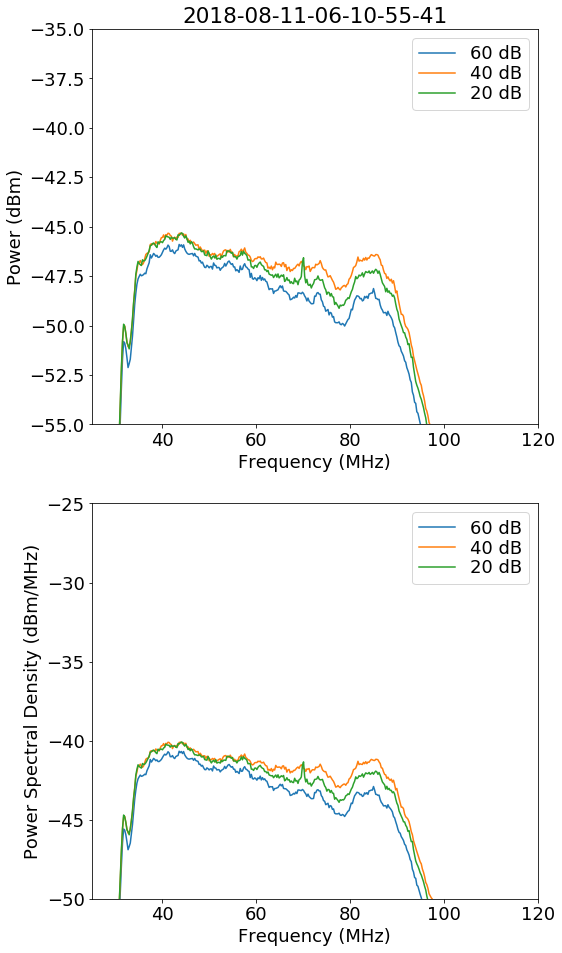

In [37]:
dates = [20180811]*6
runs  = [3,4,5,6,7,8]
names = ['60 dB', '40 dB', '20 dB', '10 dB', '0 dB', '42 MHz Notch']
for i,r in enumerate(runs[0:3]):
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'specanalyzer'])

    for j in [9]:#len(measSpecHead.keys())):
        plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j],
                    label=names[i])
    pyp.subplot(2,1,1)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-55,-35)
    #pyp.vlines([70,74,75.5], -55,-42, linestyles='--', alpha=0.3)
    pyp.subplot(2,1,2)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-50,-25)
    
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectra_60-20dB.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run5_2018-08-11_10-45-40.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run6_2018-08-11_10-52-11.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run7_2018-08-11_11-01-38.hdf5


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


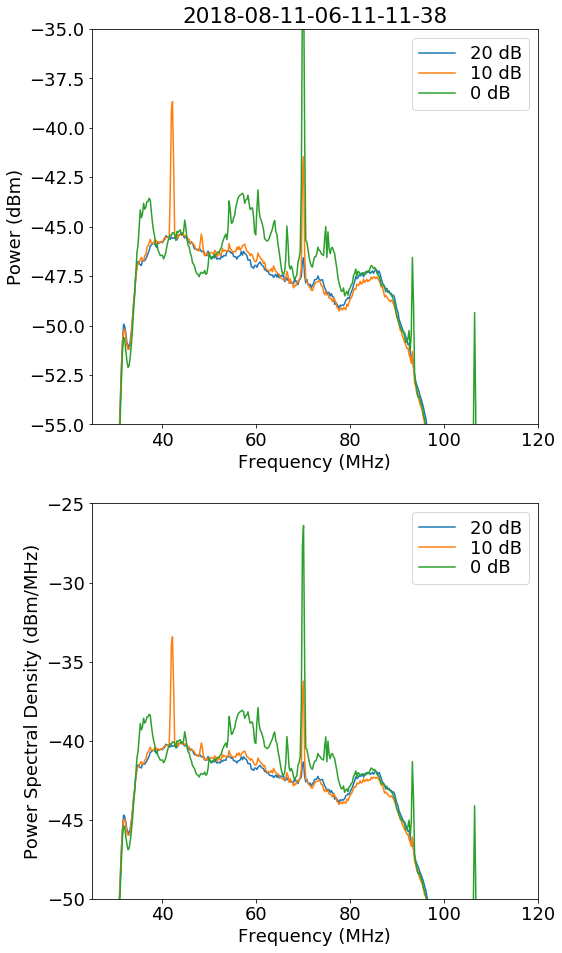

In [38]:
dates = [20180811]*6
runs  = [3,4,5,6,7,8]
names = ['60 dB', '40 dB', '20 dB', '10 dB', '0 dB', '42 MHz Notch']
for j,r in enumerate(runs[2:5]):
    i = j+2
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'specanalyzer'])

    for j in [9]:#len(measSpecHead.keys())):
        plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j],
                    label=names[i])
    pyp.subplot(2,1,1)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-55,-35)
    #pyp.vlines([70,74,75.5], -55,-42, linestyles='--', alpha=0.3)
    pyp.subplot(2,1,2)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-50,-25)
    
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectra_20-0.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run5_2018-08-11_10-45-40.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run6_2018-08-11_10-52-11.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run7_2018-08-11_11-01-38.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run8_2018-08-11_11-09-42.hdf5


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


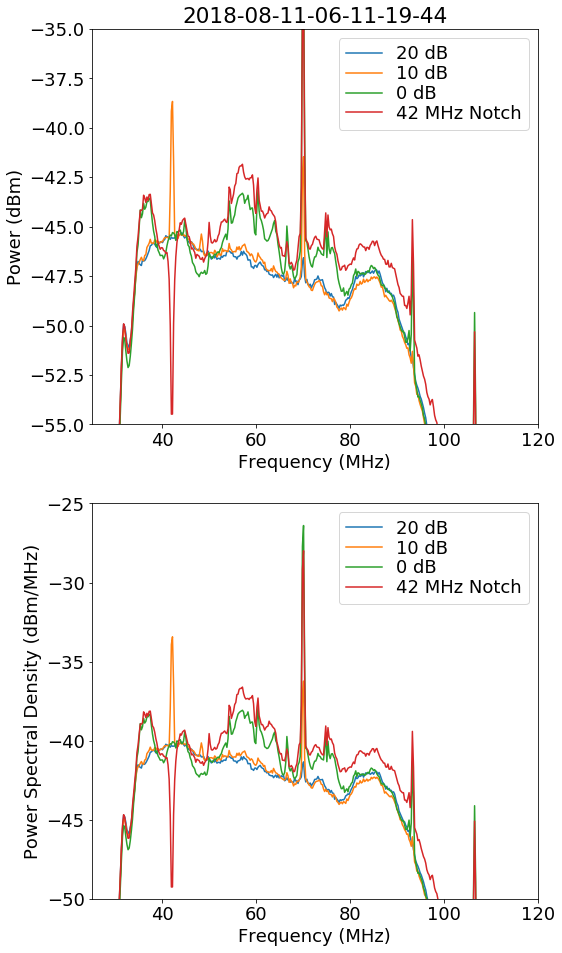

In [39]:
dates = [20180811]*6
runs  = [3,4,5,6,7,8]
names = ['60 dB', '40 dB', '20 dB', '10 dB', '0 dB', '42 MHz Notch']
for j,r in enumerate(runs[2:6]):
    i = j + 2
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'specanalyzer'])

    for j in [9]:#len(measSpecHead.keys())):
        plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j],
                    label=names[i])
    pyp.subplot(2,1,1)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-55,-35)
    #pyp.vlines([70,74,75.5], -55,-42, linestyles='--', alpha=0.3)
    pyp.subplot(2,1,2)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-50,-25)
    
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectra_20-42.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run8_2018-08-11_11-09-42.hdf5


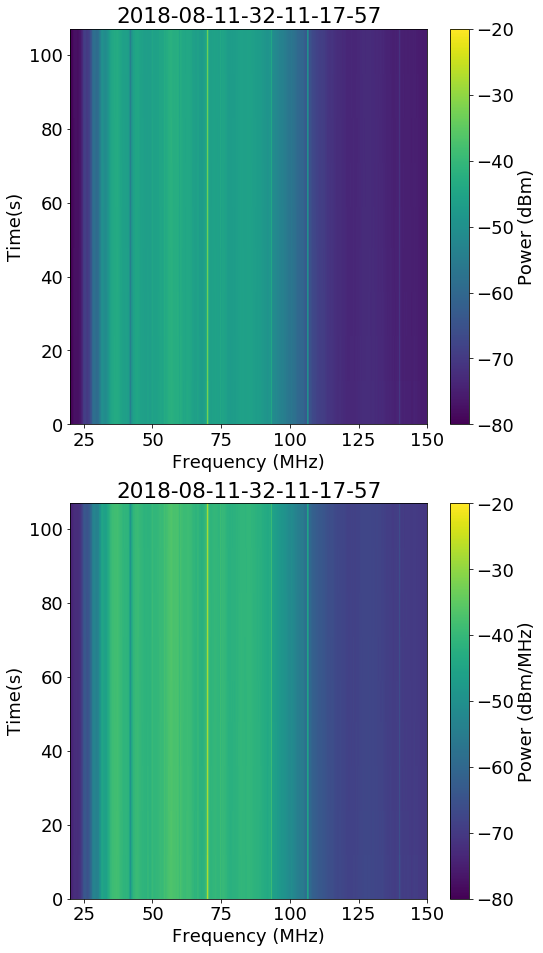

In [40]:
dates = [20180811]*6
runs  = [3,4,5,6,7,8]
names = ['60 dB', '40 dB', '20 dB', '10 dB', '0 dB', '42 MHz Notch']

i=5
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_east_vhf_vpol_spectrogram8.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run6_2018-08-11_10-52-11.hdf5


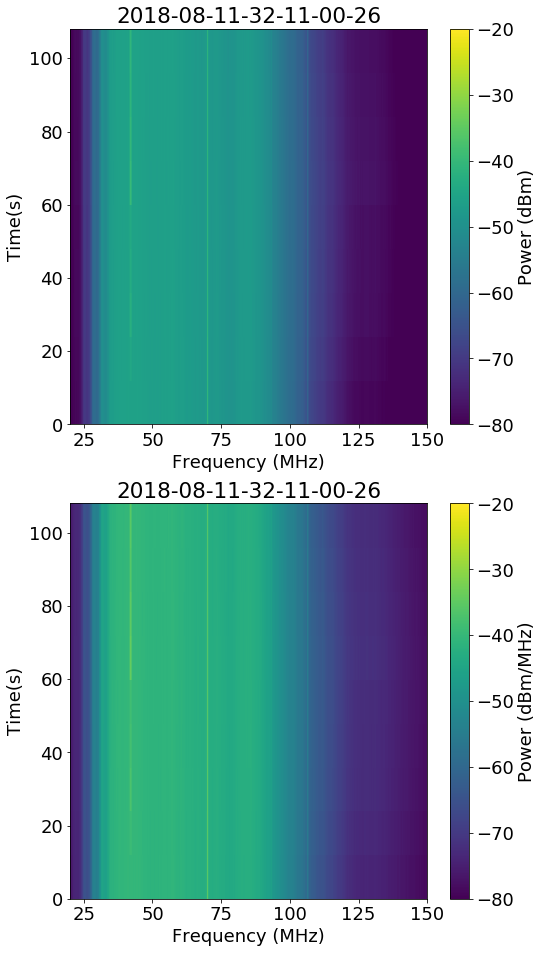

In [41]:
dates = [20180811]*6
runs  = [3,4,5,6,7,8]
names = ['60 dB', '40 dB', '20 dB', '10 dB', '0 dB', '42 MHz Notch']

i=3
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectrogram6.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run7_2018-08-11_11-01-38.hdf5


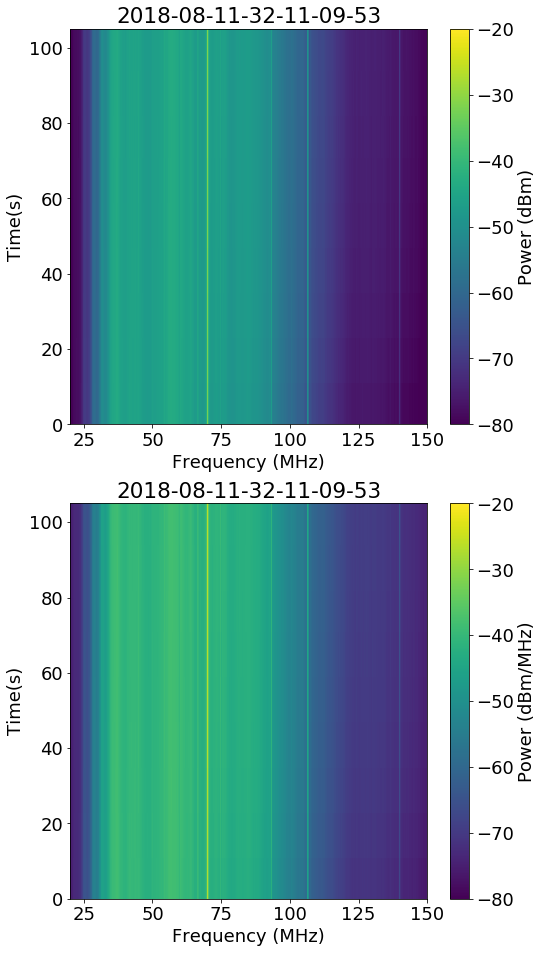

In [42]:
dates = [20180811]*6
runs  = [3,4,5,6,7,8]
names = ['60 dB', '40 dB', '20 dB', '10 dB', '0 dB', '42 MHz Notch']

i=4
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectrogram7.pdf",bbox_inches='tight')

### Hpol

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run18_2018-08-11_12-51-10.hdf5
Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run19_2018-08-11_12-54-55.hdf5


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


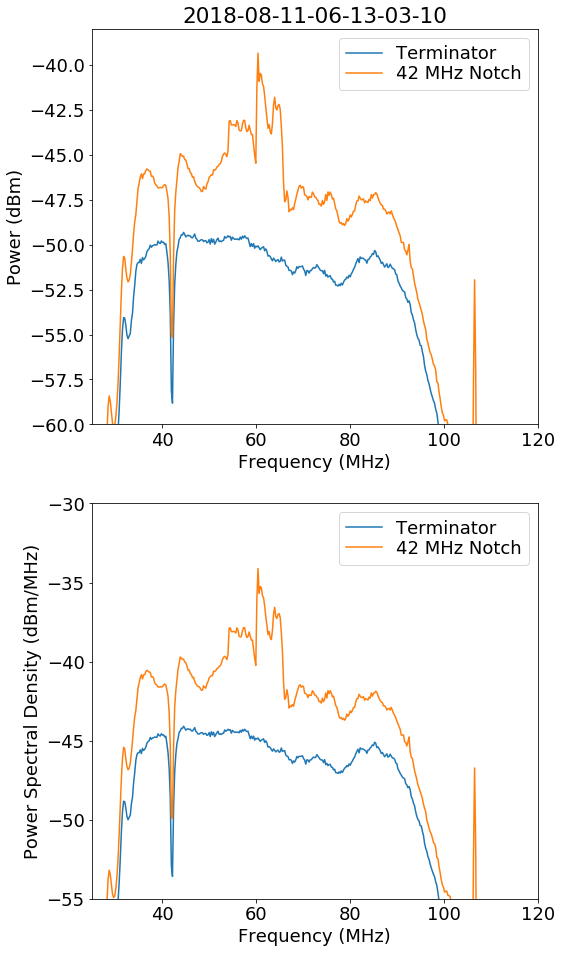

In [43]:
dates = [20180811]*2
runs  = [18,19]
names = ['Terminator', '42 MHz Notch']
for j,r in enumerate(runs):
    i = j + 0
    measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'specanalyzer'])

    for j in [0]:#len(measSpecHead.keys())):
        plotSpectrum(measSpecHead, measSpectra, measSpecHead.keys()[j],
                    label=names[i])
    pyp.subplot(2,1,1)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-60,-38)
    #pyp.vlines([70,74,75.5], -55,-42, linestyles='--', alpha=0.3)
    pyp.subplot(2,1,2)
    pyp.legend(labelspacing=0.1)
    pyp.xlim(25,120)
    pyp.ylim(-55,-30)
    
pyp.savefig(outDirc + "/observatory_west_vhf_hpol_spectra.pdf",bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run21_2018-08-11_13-07-32.hdf5


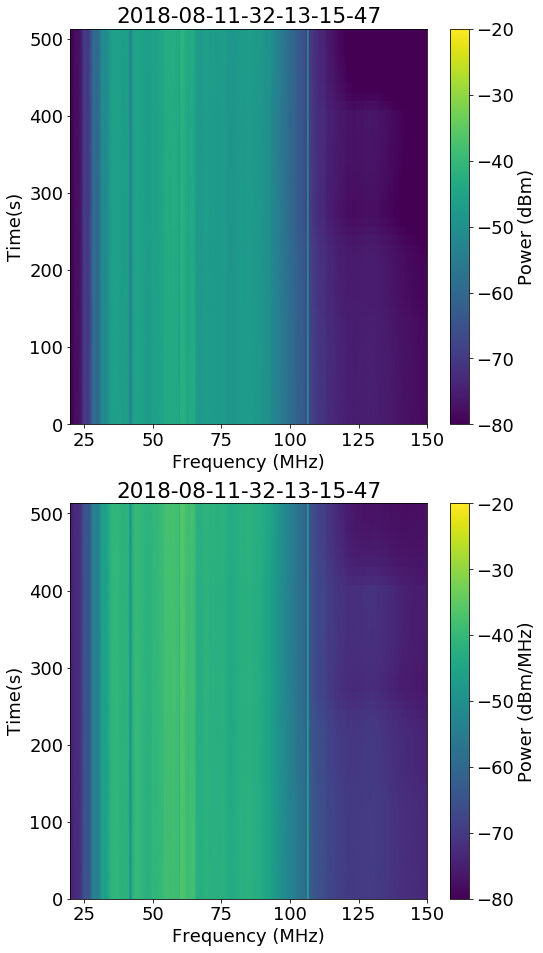

In [44]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['21','22','23']

i=0
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectrogram%s.pdf"%names[i],bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run22_2018-08-11_13-20-58.hdf5


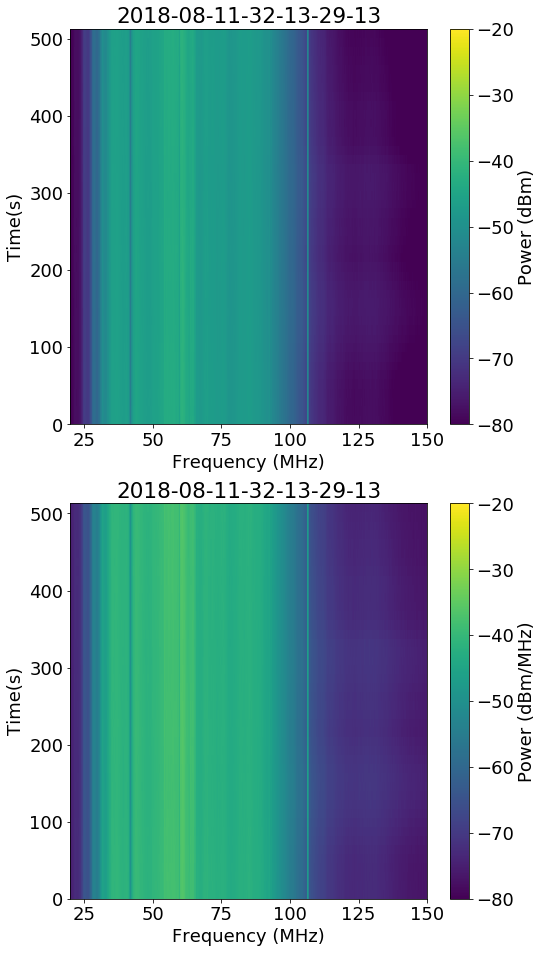

In [45]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['21','22','23']

i=1
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectrogram%s.pdf"%names[i],bbox_inches='tight')

Spectrum Analyzer File Name /home/radio/data/beacon_august2018//20180811/specanalyzer_run23_2018-08-11_13-31-51.hdf5


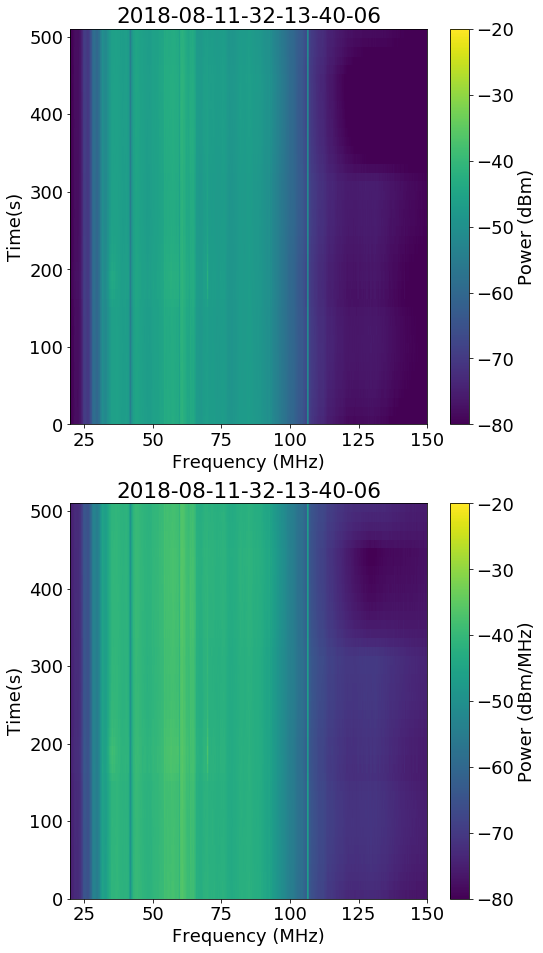

In [46]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['21','22','23']

i=2
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'specanalyzer'])

plotSpectrogram(measSpecHead,measSpectra,label=names[i])
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_spectrogram%s.pdf"%names[i],bbox_inches='tight')

## Waveforms

### Vpol

In [47]:
dates = [20180811, 20180811, 20180811]
runs  = [      14,       15,       16]
names = ['', '', '', '']

i = 1
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                    runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180811/20180811/tekScope_run15_20180811_12-22-51-004944.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


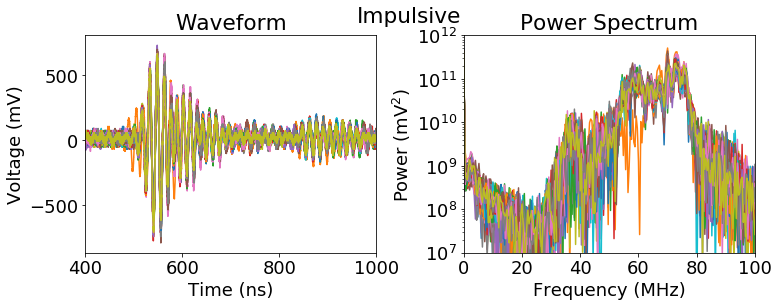

In [48]:
therm_ind = list(range(34,50)) + list(range(65, 98))

#good_ind = [34,35,36,37...
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulsive")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(400, 1000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e12)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_pulses_scope.jpg",bbox_inches='tight')

/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


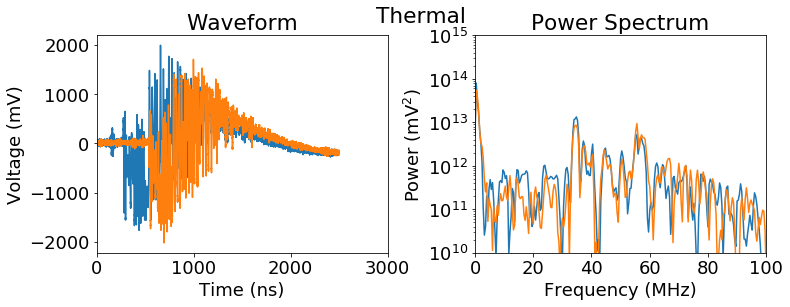

In [49]:
therm_ind = [55,64]

#good_ind = [34,35,36,37...
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Thermal")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(0, 3000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e10,1e15)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_west_vhf_vpol_bigpulses_scope.jpg",bbox_inches='tight')

### Hpol

In [50]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['21','22','23']

i=0
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180811/20180811/tekScope_run21_20180811_13-07-35-862101.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


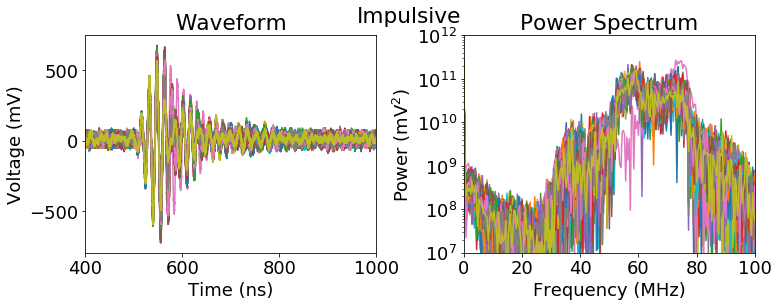

In [51]:
therm_ind = range(99)
#good_ind = [34,35,36,37...
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulsive")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(400, 1000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e12)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_west_vhf_hpol_pulses_scope.jpg",bbox_inches='tight')

In [52]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['21','22','23']

i=1
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180811/20180811/tekScope_run22_20180811_13-21-02-034470.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


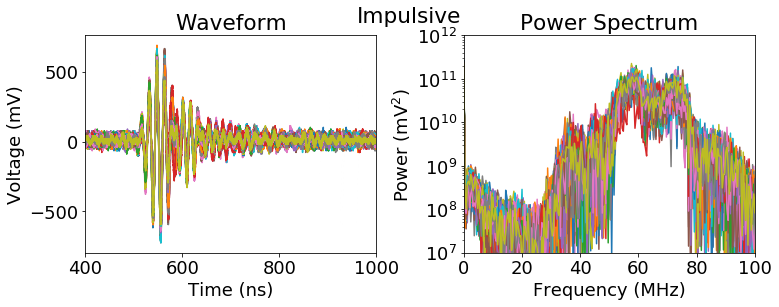

In [53]:

therm_ind = range(99)
#good_ind = [34,35,36,37...
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulsive")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(400, 1000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e12)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_west_vhf_hpol_pulses22_scope.jpg",bbox_inches='tight')

In [54]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['21','22','23']

i=2
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180811/20180811/tekScope_run23_20180811_13-31-55-066169.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


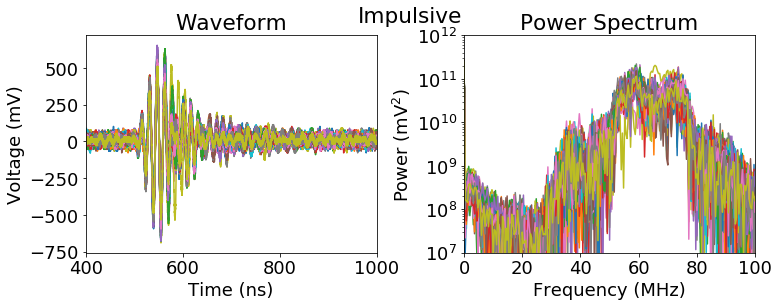

In [55]:
therm_ind = range(99)
#good_ind = [34,35,36,37...
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulsive")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(400, 1000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e12)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_west_vhf_hpol_pulses23_scope.jpg",bbox_inches='tight')

In [56]:
dates = [20180811]*3
runs  = [21,22,23]
names = ['19']

i=0
measSpecHead, measSpectra, measRatesHead, measRates, measWaves = getData(
                                runs[i], dates[i], [ 'tekScope'])

Scope File Name  /home/radio/data/beacon_august2018//20180811/20180811/tekScope_run21_20180811_13-07-35-862101.csv


/home/radio/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


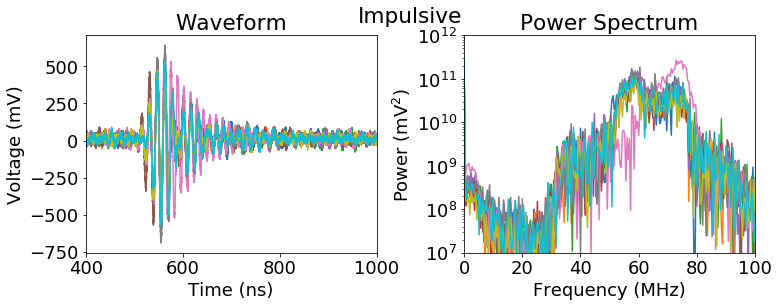

In [57]:
therm_ind = range(10)
#good_ind = [34,35,36,37...
for eid in measWaves.keys()[therm_ind]:
        draw_channel(measWaves, eid,0)

pyp.suptitle("Impulsive")
pyp.subplot(1,2,1)
pyp.xlabel("Time (ns)")
pyp.ylabel("Voltage (mV)")
pyp.xlim(400, 1000)
pyp.subplot(1,2,2)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Power (mV$^2$)")
#pyp.xlim(700, 1000)
pyp.ylim(1e7,1e12)
pyp.xlim(0,100)
pyp.subplots_adjust(wspace=0.3,hspace=1)
pyp.savefig(outDirc + "/observatory_west_vhf_hpol_pulses18_scope.jpg",bbox_inches='tight')